# FINAL NOTEBOOK

The final notebook consists of two parts: Milestone II and milestone II.

# MILESTONE II

In this part we acquint ourselves with the recipe data. First we show we are gonna prepropcess this data. We explain how we are gonna handle the data size. Next how we will handle the missing data and how we are gonna enrich our data set. <br>
Using this info we will conclude how this data suits our needs for the project and reset our goals accordingly. We will explain our new goals and the pipline how we are gonna reach these goals.<br>
Let's get sarted!

## 0. RECAP: WHAT DO WE WANT TO ACCLOMPISH?

In the first milestone of the project we showed a lot of possible research questions and possibilities to do with the recipe data. Those research questions where:

-  "Are there subsets of ingredients that are regularly used together and subsets that are never combined with each other and what is a good way to visualize this?".

-  "Are certain ingredients associated more than others and therefore form a basis must have of ingredients at home?

-  "Is it possible to, based on the subsets, generate new recipes or propose ingredients that go well with the ingredients that you have at home? "

-  "Can we propose enhancements to certain recipes?" .

-  "Based on the ratings of the recipes,is it possible to find certain combinations that are loved more than others?"
<br>
<br>
The feedback on milestone one was that we had too many research questions. We will now look at our data and decides which questions we willanswer, why we chose those questions , and how we are going to answer en present it.

## 1. GETTING FAMILIAR WITH THE DATA

### The .tsv file

The recipe data sets consist of two parts. One part is a .tsv file in the info folder the other part are a lot of .html pages with recipe data. Let's first have a look at what is in the .tsv file.

In [1]:
import pandas as pd
import helpers as h
import numpy as np
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

529


In [2]:
from importlib import  reload
reload(h)


529


<module 'helpers' from '/Users/adriaan/Documents/epfl/sem1/applied data science/github claas/project/helpers.py'>

In [3]:
infoDf=h.load_tsv()
infoDf.sample(5,random_state=1)

,domain,url,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol,title,title_bag-of-words,ingredients_list,ingredients_bag-of-words
1981,foodnetwork.com,http://www.foodnetwork.com/paulas-home-cooking...,?,?,?,?,?,?,Racing Car Dishes : Paula's Home Cooking : Foo...,'s : car cooking dishes food home network paul...,NaN,NaN
59723,allrecipes.com,http://allrecipes.com/Recipe/Dilly-Potato-Sala...,170,100,37.8,33.6,131,160,Dilly Potato Salad Recipe,dilly potato recipe salad,"2 pounds red potatoes, diced|6 hard-cooked egg...",", 1 1\/4 2 3 6 chopped cup diced dijon-style d..."
13413,allrecipes.com,http://allrecipes.com/Recipe/Lentil-Soup-2/Det...,248,130,53.1,53.2,279,6,Lentil Soup Recipe,lentil recipe soup,"2 tablespoons olive oil|2 large onions, cubed|...",", - 1 1\/2 1 1\/2 2 3 3\/4 3 1\/2 7 and bay bl..."
3491,epicurious.com,http://www.epicurious.com/recipes/food/views/Y...,?,?,?,?,?,?,Yellow Cake Recipe,cake recipe yellow,2 cups cake flour (not self-rising)|2 teaspoon...,", -lrb- -rrb- 1 1\/2 1 1\/2 2 3 30 3\/4 at bak..."
10056,allrecipes.com,http://allrecipes.com/Recipes/Appetizers-and-S...,?,?,?,?,?,?,Best Salsa Recipes,best recipes salsa,NaN,NaN


We succesfully loaded the data set but as you can see there is a whole lot of missing and messy data that should be cleaned out. Let's have a look at some examples

<b>Example 1: messy data

In [4]:
pd.DataFrame(infoDf.iloc[12789])

,12789
domain,cdkitchen.com
url,http://www.cdkitchen.com/recipes/dish/sauces-a...
kcal_total,?
kcal_carb,?
kcal_fat,?
kcal_protein,?
mg_sodium,?
mg_cholesterol,?
title,Alfredo Sauce Recipes
title_bag-of-words,alfredo recipes sauce


As one can see this is almost empty and will therefore not add any new usefull information that we can use for our flavor analysis. Since we are interested in the ingredients we can remove all the entities that have no ingredient_list or ingredients_bag-of-words. But before we do that let's make sure that throwing away those datarows is justified.

In [5]:
countedSeries=infoDf.count()
assert(countedSeries.get("ingredients_list")==countedSeries.get("ingredients_bag-of-words"))
throwAwayPercentage=(len(infoDf)-countedSeries.get("ingredients_list"))/len(infoDf)*100
print(str(throwAwayPercentage.round(2)) + "% has no information about the ingredients")

29.06% has no information about the ingredients


Can we justify throwing away almost 30% of our data rows? Or should we come up with an alogithm to fill in the missing points? Let's have a look at some of the pages that are thrown away.

The example site can be found on the link: http://www.cdkitchen.com/recipes/dish/sauces-and-condiments/alfredo-sauce . When going to this link we can see that it is some kind of general page for alfrede-sauces with links to different recipies. Another example of an empty row would be http://allrecipes.com/Recipes/fruits-and-vegetables/fruits/mangos/main.aspx which is also a general page for recipies with mangos. This indicates that it is indeed safe to throw those data rows away.

In [6]:
#Throw the rows away
infoDf.dropna(subset=["ingredients_list", "ingredients_bag-of-words"], how='all',inplace=True)

<b>Example 2: messy data

In [7]:
columnsOfInterest=["title","title_bag-of-words","ingredients_list","ingredients_bag-of-words"]

The bag of words and the ingredient list are sometimes quite messy. Let's have a look at two typical rows.

In [8]:
print("ingredient list:   " +str(infoDf.iloc[31251]["ingredients_list"]))
print("")
print("ingredients bag of words: "+str(infoDf.iloc[31251]["ingredients_bag-of-words"]))

ingredient list:   2 cups nonfat milk|2 tablespoons non-fat powdered milk|3/4 cup egg substitute|1/3 cup Splenda sugar substitute|1 teaspoon vanilla extract|3 teaspoons sugar

ingredients bag of words: 1 1\/3 2 3 3\/4 cup cups egg extract milk non-fat nonfat powdered splenda substitute sugar tablespoons teaspoon teaspoons vanilla


In [9]:
print("ingredient list:   " +str(infoDf.iloc[44004]["ingredients_list"]))
print("")
print("ingredients bag of words: "+str(infoDf.iloc[44004]["ingredients_bag-of-words"]))


ingredient list:   1 (10-ounce) bag baby spinach|1 ripe Bartlett pear, cored and thinly sliced|1 small red onion, thinly sliced|1 (4-ounce) package crumbled blue cheese|Sugared Curried Walnuts|Maple-Cider Vinaigrette

ingredients bag of words: , -lrb- -rrb- 1 10-ounce 4-ounce and baby bag bartlett blue cheese cored crumbled curried maple-cider onion package pear red ripe sliced small spinach sugared thinly vinaigrette walnuts


Note that in both cases the bag-of-words of ingredients does not really bring a lot of extra value to the used ingredients or even the way they are prepared! We will therefore only look at the the ingredient list in what follows. 

However this ingredient list is not useable yet.We should find a systematic and smart way to standardize our ingredients. Our goal is to get a clean list of ingredients for each recipe. How this goal is accomplished is explained in section 2: Standardazing and cleaning the data.

### The html files

We already had a look at the .tsv file. This tsv file was obtained by webscraping from arround 70.000 webpages. This webpages are given to us as downloaded html files. To retrieve the webpages from their corresponding url we can ms.log file. The only reason why we would use these would be enrich our data set with the rating of the recipies and hance find more loved flavor combinations than others. 

We decided not to implement this for the following reasons:
-  There are 14 different domains and each domain requires a specific algorithm to scrape the rating
-  Since the user base from the sites are different some sites may grade more severly than others
-  Not every domain has a rating system.
-  There is more than enough interesting stuff to analyze with the ingredients alone! 


In [10]:
#How many different domains are there
len(np.unique(infoDf["domain"]))

14

## 2. STANDARDIZING AND CLEANING THE DATA

As the saying for data analysis/machine learning goes: "garbage in, garbage out". The main goal of this section is therefore to come up with an algorithm that cleans our data. The full implementation of the used functions is, to not overload the notebook, placed in the helpers.py file. No worries the functions and the reasoning behind them are still explained in the notebook

As we saw in the examples earlier the ingredient list is quite messy. Since we are mainly interested different ingredients we will remove all quantities (numbers) and quantity units (ounce, pound, teaspoon, cup,...) . Nonsense words like "-lrb-" or "-rrb-" probably coming from html webscraping will be removed as well. We also should remove adjectives like thinly, sliced, small,... However not all adjectives should be removed for example we would like to keep the information about "blue cheese".  Since the goal is to identify different ingredients we will try to match each ingredient with an ingredient from a known data base. 
This known database scraped from http://www.supercook.com which has quite an impressive lists of ingredients that will be used to do the matching.
The challenge is now to find a good algorithm than matches each valid ingredient from our infoDf to this database. 

Throughout the standardization we will use 2 different examples.

In [11]:
#EXAMPLE 1
infoDf.iloc[31251].ingredients_list

'2 cups nonfat milk|2 tablespoons non-fat powdered milk|3/4 cup egg substitute|1/3 cup Splenda sugar substitute|1 teaspoon vanilla extract|3 teaspoons sugar'

In [12]:
#EXAMPLE 2
infoDf.iloc[0].ingredients_list

'put one half cup of milk, 4 tablespoons of chocolate syrup, Vanilla extract and Ice to taste in whatever your using to blend it. Blend until satisfied with the texture and serve.|Now what are you waiting for?|go on! enjoy!'

### 2.1 Split and remove the uneccesairy items

Here we want to use the information of the seperator | which should indicate that a new ingredient is starting. However as we can see in the second example this is not always used correctly.
So how are we going to clean this? First we try to split it into ingredients according to | operator because in most cases this still indicates a new ingredient. After it is splitted we try to remove the unecessairy words from that list. This is done in the makeIngredientList function. We illustrate with the 2 examples. But before we do it let's first make all the nouns signular and lower case. This is done wy the morphy_lower function in the helpers file.

In [13]:
lowerStemmedIngredients = infoDf["ingredients_list"].apply(h.morphy_lower)
infoDf["ingredients_list"]=lowerStemmedIngredients

Now it's time to split the ingredient list in different ingredients and remove the unecessairy items from each in gredient. The uneccesairy items removes all informationless features like weightUnits etc as described at the beginning of the section. The power of the function is best illustrated on a bag of words.

In [14]:
ingredientListEX1=h.makeIngredientList(infoDf.iloc[31251]["ingredients_list"])
print("before: " +infoDf.iloc[31251]["ingredients_list"])
print("")
print("after: "+str(ingredientListEX1))
print("")
ingredientListEX2=h.makeIngredientList(infoDf.iloc[0]["ingredients_list"])
print("")
print("before: " +infoDf.iloc[0]["ingredients_list"])
print("")
print("after: "+str(ingredientListEX2))

before: 2 cup nonfat milk|2 tablespoon non-fat powder milk|3/4 cup egg substitute|1/3 cup splenda sugar substitute|1 teaspoon vanilla extract|3 teaspoon sugar

after: ['nonfat milk', 'non-fat powder milk', 'egg substitute', 'splenda sugar substitute', 'vanilla extract', 'sugar']


before: put one half cup of milk, 4 tablespoon of chocolate syrup, vanilla extract and ice to taste in whatever your using to blend it. blend until satisfy with the texture and serve.|now what are you waiting for?|go on! enjoy!

after: ['put one milk, chocolate syrup, vanilla extract ice taste whatever using blend it. blend satisfy texture serve.', 'waiting for?', 'go']


This already looks a lot better however still not close enough to a standardized ingredient list defenitly not in the second case.

### 2.2 match with external database

As one can see in the previous section example 1 worked out OK while the second example is still far away from a standardized ingredient set.
We now try to match certain word or word combinations from our extracted ingredient database from supercook.com. But first let's do the same cleaning process as before. In this case this is just taking lower case and morphing the word. 

In [15]:
#get the total list of ingredients from supercook.com
totalList=h.returnTotalList()
#Let's remove all the capitals and all the plurals as before
from nltk.corpus import wordnet
temp=[]
for s in totalList:
    temp.append(h.morphy_lower(s))
totalList=temp

Finding the best match/matches from an ingredient from the ingredient list is done in the findBestMatch function.
This function campares te given element from the ingredient list to the database and extracts the ingredients that are similar. This is done as follow: first it looks at two word combinations like: chocolate syrop or blue cheese. Then it looks at matching single words. 

In [16]:
#EXAMPLE 1
[h.findBestMatch(ingredient) for ingredient in ingredientListEX1]

[['milk'], ['powdered milk'], [], ['sugar'], ['vanilla'], ['sugar']]

In [17]:
#EXAMPLE 2
[h.findBestMatch(ingredient) for ingredient in ingredientListEX2]

[['chocolate syrup', 'milk', 'vanilla'], [], []]

Combining all the previous functions together gives the finalClean function. The implementation is shown below and can also be found in the helpers file.

In [18]:
def finalClean(s):
    ingredientList=h.makeIngredientList(s)
    resultList=[]
    #print(ingredientList)
    for s in ingredientList:
        bestMatch=h.findBestMatch(s)
        resultList=resultList+bestMatch
    return str(set(resultList))#Remove duplicates and convert to a string.

Let's have a final look at our two examples.

In [19]:
print("before: " +infoDf.iloc[31251]["ingredients_list"])
print("")
print("after: "+h.finalClean(infoDf.iloc[31251]["ingredients_list"]))
print("")
ingredientListEX2=h.makeIngredientList(infoDf.iloc[0]["ingredients_list"])
print("")
print("before: " +infoDf.iloc[0]["ingredients_list"])
print("")
print("after: "+h.finalClean(infoDf.iloc[0]["ingredients_list"]))



before: 2 cup nonfat milk|2 tablespoon non-fat powder milk|3/4 cup egg substitute|1/3 cup splenda sugar substitute|1 teaspoon vanilla extract|3 teaspoon sugar

after: {'milk', 'vanilla', 'powdered milk', 'sugar'}


before: put one half cup of milk, 4 tablespoon of chocolate syrup, vanilla extract and ice to taste in whatever your using to blend it. blend until satisfy with the texture and serve.|now what are you waiting for?|go on! enjoy!

after: {'milk', 'vanilla', 'chocolate syrup'}


This is exactly what we were looking for. Let's apply it to a bigger scale. For convience we take a smaller subsample because running it on the whole data set takes quite a lot of time. The result of the whole dataset was saved as finalDf.csv. 

In [20]:
sampleSize=50
import time
start_time = time.time()
cleaned = infoDf["ingredients_list"].sample(sampleSize,random_state=1).apply(finalClean)
T=(time.time() - start_time)
print("--- %s seconds ---" % T)
print("ESTIMATED TOTAL TIME: "+str(T*len(infoDf)/sampleSize/60) +" minutes")

--- 3.078394889831543 seconds ---
ESTIMATED TOTAL TIME: 51.26348396873474 minutes


Displaying the subsample with their ingredients.

In [21]:
pd.set_option('display.max_colwidth', -1)
subDf=pd.DataFrame(infoDf["ingredients_list"])
subDf["standardized"]=cleaned
subDf.dropna(axis=0)

,ingredients_list,standardized
121,"16 ounce water|1/8-ounce yeast|1/2-ounce salt|2 pound bread flour|1/4 cup olive oil|1/4 cup cornmeal|2 cup tomato sauce, jar or homemade|2 cup shred mozzarella|1/2 cup slice mushrooms|1/2 cup spinach, shredded|1/2 cup grate romano|1/2 cup slice pepperoni|1/2 cup grate parmesan","{'water', 'salt', 'mozzarella', 'yeast', 'pepperoni', 'bread flour', 'cornmeal', 'tomato sauce', 'romano', 'spinach', 'olive oil', 'mushroom', 'parmesan'}"
176,2 cup sift confectioners' sugar|1/2 cup butter|1 teaspoon vanilla extract|1 1/2 tablespoon milk|2 tablespoon cocoa powder (optional),"{'milk', 'vanilla', 'confectioners sugar', 'butter'}"
1119,"1 pound french green lentil (recommended: du puy)|1/4 cup olive oil, plus extra for serving|4 cup dice yellow onion (3 large)|4 cup chop leeks, white and light green parts only (2 leeks)|1 tablespoon mince garlic (2 large cloves)|1 tablespoon kosher salt|1 1/2 teaspoon freshly ground black pepper|1 tablespoon mince fresh thyme leaves|1 teaspoon ground cumin|3 cup medium dice celery (8 stalks)|3 cup medium dice carrot (4 to 6 carrots)|3 quart homemade chicken stock, recipe follows, or can broth|1/4 cup tomato paste|1 pound kielbasa, cut in 1/2 lengthwise and slice 1/3-inch thick|2 tablespoon dry red wine or red wine vinegar|freshly grate parmesan, for serving|3 (5-pound) chickens|3 large onions, unpeeled and quartered|6 carrots, unpeeled and halved|4 celery stalk with leaves, cut in thirds|4 parsnips, unpeeled and cut in 1/2, optional|20 sprig fresh flat-leaf parsley|15 sprig fresh thyme|20 sprig fresh dill|1 head garlic, unpeeled and cut in 1/2 crosswise|2 tablespoon kosher salt|2 teaspoon whole black peppercorn","{'parsley', 'dill', 'salt', 'ground chicken', 'olive oil', 'thyme', 'garlic', 'carrot', 'red wine', 'chicken soup', 'tomato paste', 'parmesan', 'celery', 'onion', 'lentil', 'peppercorn'}"
2759,"4 eggs|1 1/4 cup vegetable oil|2 cup white sugar|2 teaspoon vanilla extract|2 cup all-purpose flour|2 teaspoon baking soda|2 teaspoon baking powder|1/2 teaspoon salt|2 teaspoon ground cinnamon|3 cup grate carrots|1 cup chop pecans|1/2 cup butter, softened|8 ounce cream cheese, softened|4 cup confectioners' sugar|1 teaspoon vanilla extract|1 cup chop pecan","{'salt', 'flour', 'baking soda', 'cinnamon', 'butter', 'vanilla', 'carrot', 'pecan', 'confectioners sugar', 'vegetable oil', 'eggs', 'sugar', 'cream cheese', 'baking powder'}"
4429,"1 (32 ounce) package freeze hash brown potatoes|8 ounce cooked, dice ham|2 (10.75 ounce) can condense cream of potato soup|1 (16 ounce) container sour cream|2 cup shred sharp cheddar cheese|1 1/2 cup grate parmesan cheese","{'cream', 'cheddar', 'sour cream', 'potato', 'ham', 'parmesan'}"
4571,2 (16 ounce) package miniature smoke sausage links|1 (8 ounce) jar grape jelly|1 (12 ounce) bottle barbeque sauce,"{'sausage', 'grape'}"
5500,"2 pound sweet potatoes, peel and cut into cubes|1/2 vidalia onion, finely chopped|1 red pepper, seed and finely chopped|4 green onions, thinly sliced|1/3 cup mayonnaise|2 tablespoon orange juice|1 teaspoon smoke paprika|1/2 teaspoon ground cumin|salt and freshly ground black pepper","{'ground chicken', 'salt', 'red pepper', 'orange juice', 'paprika', 'mayonnaise', 'sweet potato', 'onion'}"
6167,1/4 cup dark chocolate chips|1 5/8 ounce butter|1 egg|1/8 cup sugar|1/8 cup flour (plus an extra pinch or two),"{'chips', 'flour', 'butter', 'chocolate', 'eggs', 'sugar'}"
6200,"2 1/2 cup chicken broth (swanson regular, natural goodness or certify organic)|1 dash ground black pepper, generous dash|2 stalk celery, coarsely chopped|1 large onion, coarsely chopped|1 (16 ounce) package herb season stuffing mix, pepperidge farm brand recommend","{'brandy', 'stuffing mix', 'celery', 'onion', 'chicken broth'}"
7835,"3 medium beets, peel and cut into 1 inch cubes|1 large turnip, peel and cubed|1 cup pearl onions, peeled|1/4 cup olive oil|1/2 teaspoon dry rosemary|salt to taste","{'rosemary', 'onion', 'salt', 'olive oil'}"


In [22]:
#UNCOMMENT THIS IF YOU WANT TO GENERATE THE FINAL DF YOURSELF
cleanedFinal=infoDf["ingredients_list"].apply(finalClean)
cleanedFinal.to_csv("cleanedFinal.csv")
infoDf["finalIngredients"]=cleanedFinal
infoDf.to_csv("finalDF.csv")

,domain,url,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol,title,title_bag-of-words,ingredients_list,ingredients_bag-of-words,finalIngredients
0,recipes.sparkpeople.com,http://recipes.sparkpeople.com/recipe-detail.asp?recipe=1191905,257.1,220,7.2,21.2,95.4,2.5,Easy Light Chocolate Milkshake Recipe,chocolate easy light milkshake recipe,"put one half cup of milk, 4 tablespoon of chocolate syrup, vanilla extract and ice to taste in whatever your using to blend it. blend until satisfy with the texture and serve.|now what are you waiting for?|go on! enjoy!","! , . 4 ? and are blend chocolate cup enjoy extract for go half ice in it milk now of on one put satisfied serve syrup tablespoons taste texture the to until using vanilla waiting what whatever with you your","{'vanilla', 'chocolate syrup', 'milk'}"
1,foodnetwork.com,http://www.foodnetwork.com/recipes/rachael-rays-tasty-travels/lamb-stew-recipe/index.html,?,?,?,?,?,?,Lamb Stew Recipe : : Recipes : Food Network,: food lamb network recipe recipes stew,"5 yellow onions|2 turnips|5 carrots|1 stalk fennel|1 cup cooking oil, divided|1 1/2 gallon chicken stock|1/2 head garlic|1/4 gallon orange juice|1/4 gallon apple cider|1/4 cup coriander seeds|1/8 cup fennel seeds|1 star anise|2 tablespoon cumin seeds|1/8 cup orange zest|1 teaspoon salt|1/2 tablespoon freshly ground black pepper|1 leg of lamb|3 cup dry white wine|salt and freshly ground pepper|your choice fresh herbs, minced, to taste",", 1 1\/2 1\/4 1\/8 1 1\/2 2 3 5 and anise apple black carrots chicken choice cider cooking coriander cumin cup cups divided dry fennel fresh freshly gallon gallons garlic ground head herbs juice lamb leg minced of oil onions orange pepper salt seeds stalk star stock tablespoon tablespoons taste teaspoon to turnips white wine yellow your zest","{'carrot', 'coriander', 'garlic', 'star anise', 'orange juice', 'white wine', 'leg of lamb', 'herbs', 'orange', 'onion', 'cumin', 'salt', 'apple cider'}"
2,foodnetwork.com,http://www.foodnetwork.com/recipes/paula-deen/chocolate-bread-pudding-recipe/index.html,?,?,?,?,?,?,Chocolate Bread Pudding Recipe : Paula Deen : Recipes : Food Network,: bread chocolate deen food network paula pudding recipe recipes,"1 (1-pound) loaf french or italian bread, cubed|3 cup milk|1/4 cup heavy cream|1/2 cup coffee flavor liqueur|1 cup sugar|1 cup pack light brown sugar|1/4 cup cocoa powder|1 tablespoon vanilla extract|2 teaspoon almond extract|1 1/2 teaspoon cinnamon|6 eggs, lightly beaten|8 ounce semisweet chocolate, grated|whipped cream (optional)",", -lrb- -rrb- 1 1-pound 1\/2 1\/4 1 1\/2 2 3 6 8 almond beaten bread brown chocolate cinnamon cocoa coffee cream cubed cup cups eggs extract flavored french grated heavy italian light lightly liqueur loaf milk optional or ounces packed powder semisweet sugar tablespoon teaspoon teaspoons vanilla whipped","{'almond meal', 'liqueur', 'vanilla', 'milk', 'sugar', 'ice cream', 'coffee', 'cinnamon', 'chocolate', 'onion powder', 'bread', 'eggs', 'whipped cream'}"
3,cdkitchen.com,http://www.cdkitchen.com/recipes/recs/32/Snowball_Cookies_II54545.shtml,?,?,?,?,?,?,Snowball Cookies II Recipe,cookies ii recipe snowball,1/2 cup powder sugar|1/3 cup butter or margarine|2 cup bisquick baking mix|1/2 cup chop nuts|1 teaspoon almond extract|2 tablespoon water|powdered sugar,1 1\/2 1\/3 2 almond baking bisquick butter chopped cup cups extract margarine mix nuts or powdered sugar tablespoons teaspoon water,"{'bisquick', 'almond meal', 'water', 'sugar', 'butter'}"
4,cdkitchen.com,http://www.cdkitchen.com/recipes/recs/38/Old_Fashioned_Butterscotch_Pie42680.shtml,192,120,63,12,?,?,Old Fashioned Butterscotch Pie Recipe #31698,# 31698 butterscotch fashioned old pie recipe,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tablespoon flour|1 cup milk|4 tablespoon butter|1 teaspoon vanilla extract|1/4 teaspoon salt|1/2 teaspoon cream of tartar|4 tablespoon granulate or powder sugar,1 1\/2 1\/4 1 1\/2 3 4 brown butter cream cup eggs extract flour

In [ ]:
cleanedFinal

In [ ]:
infoDf["finalIngredients"]=cleanedFinal[cleanedFinal.columns[1]]

In [ ]:
infoDf

In [ ]:
cleanedFinal = pd.read_csv("cleanedFinal.csv")
infoDf["finalIngredients"] = cleanedFinal



In [ ]:
infoDf

In [ ]:
finalDf=pd.read_csv("finalDF.csv")

## 3. WHAT CAN WE DO WITH THE DATA? 

Now that we have the final form of the data we are going the use it is time to explore the data. We will first perform an exploretary analysis in which we try to get an idea of how the ingredients are distributed over the different recipies.<br>
Using the results of our exploretary analysis we will have another look at our goals and decide which goals we want to fullfill.

### 3.1 EXPLORETARY ANALYSIS

#### 3.1.1.Frequency analysis

The thing we'll look at here is the standardized column of the finalDF.

In [ ]:
data = pd.DataFrame.from_csv('finalDF.csv')
data = data['finalIngredients']
ingredientSets=[eval(data[n]) for n in list(data.keys())]
#Make a list of all the ingredients
allIngredientsList=[]
for st in ingredientSets:
    allIngredientsList=allIngredientsList+list(st)

Let's plot a count of these ingredients note that the scale is exponentional which means that the frequency of an ingredient is almost exponential

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
countedSeries=pd.Series(Counter(allIngredientsList))
plt.close()
countedSeries.sort_values(ascending=False,inplace=True)
frequency_table=countedSeries.to_frame("Frequency of ingredients")
frequency_table.head(20)


In [ ]:
plt.close()
frequency_table.plot(logy=True)
plt.title('Frequencies of Ingredient ')
plt.show()

We see an exponential behavior which indicates that some ingredients are used way more often used than other.

#### 3.1.2 What about the associations?

In our research questions we talk a lot about associations. We quickly take a look at whether or not these associations indeed exist in our data. This will be done by using the <b>apriori algorithm</b>. The goal of the algorithm is to find associations between ingredients and to get an dea of how the variables are distributed.
Using the apriori algorithm we can get the following ideas about the ingredients
-  Support: indiciates the ratio of in how many percent of the recepies it appeared
-  Confidence: Expresses how likely one ingredient is used given that another ingredient is used
-  Lift: Expresses how likely one ingredient A is used given that another ingredient B is used while taking into account the popularity of A.


In [ ]:
#finding frequet itemset
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori

oht = OnehotTransactions()
oht_ary = oht.fit(ingredientSets).transform(ingredientSets)
df_fr = pd.DataFrame(oht_ary, columns=oht.columns_)
#min_support indicates the fraction of recipies that that combination has to be in 
frequent_itemsets = apriori(df_fr,min_support=0.02, use_colnames=True) 

In [ ]:
frequent_itemsets.sort_values("support",ascending=False).head(20)

This indicates that there are indeed some ingredients that are used often together like eggs and suger, clove& garlic,... Let's also look at the other properties that we can get from the apriori algorithm

In [ ]:
from mlxtend.frequent_patterns import association_rules
associationDf=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [ ]:
associationDf.sample(20)

Since this is still the second milestones we do not jump right away to conclusions about the associations we just showed that they are there and that the appriori algorithm is one way to get to these associations. We could also go for a different approach: working with foodnetworks.

#### 3.1.3 Associations: an alternative approach with network analysis

We create an ingredient network where an ingredient is linked with another if they appear in the same recipe. However this takes a huge amount of computing time. Therefore we only take 5% of our recipies into account. Later we will run this on the whole data set with the cluster or overnight with our own machines and save it on an external file.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#loading data into data frame
data = pd.DataFrame.from_csv('finalDF.csv')
data = data['finalIngredients']

#Initializing Dicts
ingredient_graph_array = {}

data_index = data.index.values
#Build a little network for each recipe
for n in data_index:
    proxy = nx.complete_graph(eval(data[n]))
    ingredient_graph_array[n] = nx.Graph()
    for (u,v) in proxy.edges():
        ingredient_graph_array[n].add_edge(u,v, weight =1)

#Merge the little networks into one big monster where
#the weight of the adges is incremented for each occurence of a connection 
timeIndicator = 0
for graph_iter in data_index:
    if timeIndicator%10==0:
        if timeIndicator/len(data_index)*100>5:
            print("10% of the monster is generated")
            break
    if graph_iter == 0:
        Monster = ingredient_graph_array[graph_iter]
        pass

    intersection = list(set(Monster.edges) & set(ingredient_graph_array[graph_iter].edges))

    Monster = nx.algorithms.operators.binary.compose(ingredient_graph_array[graph_iter],Monster, 'Monster')

    for edit in intersection:

        Monster[edit[0]][edit[1]]['weight'] = 1+ Monster[edit[0]][edit[1]]['weight']
    timeIndicator = timeIndicator +1

print(type(Monster))
print("nb of edges: " +str(Monster.number_of_edges()))
print("nb of nodes: "+ str(Monster.number_of_nodes()))

With this network we can try to do some visualizations and other analysis.

In [ ]:
#Visualize it
pos = nx.spring_layout(Monster, weight="weight")
nx.draw(Monster, pos,node_size=8,node_color="green",linewidths=0.005,scale=2)
plt.show()

In [ ]:
#Load the whole network with pickle
import pickle
f = open('store.pckl', 'rb')
monster = pickle.load(f)
f.close()

This looks like a monster indeed. However usefull stuff can be done by analyzing the whole network. 
For example: looking at the average degree, clustering arround certain ingredient groups,... 

### 3.2 REDISCUSSING OUR GOALS

Now that we have a network of all our ingredients and done some exploratary analysis we can truly set our goals.
We conclude on two different goals for the final deadline:
-  We will look at the subsets of different ingredients that are regulary used together and those that are never combined together. We search for a good way to visualize this. 
-  We will implement an algorithm that uses the association between different ingredients to predict and propose new ingredients given a list of ingredients. This also incorparates the goal of proposing new recipies. The final goal would be to be able to query ingredients and our algorithm will propose ingredients that are likely to go well with those.



## 4. METHODS TO ACCOMPLISH THESE GOALS

### 4.1 WHAT METHODS WILL WE USE 

#### 4.1.1 The apriori algorithm

As seen in the exploratary analysis the apriori algorithm is very powerfull to find associations. We will therefore defenitly use the output of this algorithm to predict and propose new ingredients to enhance and generate recipes.  <br>
Using the lift and confidence and other conditions we could come up with tresholds value to find some good subsets of ingredients.



#### 4.1.2 LDA modelling

To explain LDA modelling we quote the following sentence from wikipedia:
<br>
"""
<br>
In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.
<br>
"""
<br>
Why LDA modeling? LDA modeling will, based on our recipies caterogize our ingredients in the number of categories that we tell it to categorise them in. In other words:  it will try to devide the ingredients into different categories without actually knowing what they represent. LDA will do this based on which ingredient are used together and will filter out the ingredients that are used pretty much everywhere. 

When tuned properly LDA can gives us usefull insights in ingredients associations that the appriori algorithm might have missed. LDA needs tuning in the parameters alpha and beta. We will chose a low alpha value which indicates that each recipe only will belong to a few categories and a little higher beta value to indicate that each category is composed of multiple words.

We will use LDA where each recipe is handled as a little document. We might have to filter out the recipies with very few ingredients, this is something that we'll have to see when implementing the algorithm.

Conclusion: our goal with LDA is to provide a way to classify list of ingredients to different categories. This might help us to give better predictions and propose better ingredients

#### 4.1.3 Network analysis

Network analysis can also be a really powerfull tool answer certain questions. It gives an idea of how well connected our ingredients our. We will use it to find the anti-associaitons of certain ingredients or groups of ingredients.
Networks are also a nice thing to visualize on the poster, it quickly gives an idea of how the recipe database is connected. One could see clusters and even make interactive plots.  However, as seen in the exploretary analysis, on must watch out not to overkill the plots.


### 4.2 CONCLUSION METHODS

Based on the results of the different methods we will be able to design the algorithm to generate and enhance certain recipies.
The appriori model will be our main backbone of the algorithm. Network analysis will make sure that certain ingredients are not matched. Depending on the results of LDA we will use it in the algorithm or not. If it is not used in the algorithm it can still be used to perform a classification of the generated recipe and see how close it is to certain not generated recipies.  

## 5. DEFINING OUR PLANNING

Before the project deadline there is still a lot of work that we have to do.
-  We tune and make the machine learning methods work (week 4/12-10/12)
-  We write about the machine learning method in our report (week 4/12-10/12)
-  We design and implement the algorithm (11/12-17/12)
-  We focus on visualization and how to presentate our results (11/12-17/12)
-  We write the rest of our report (11/12-17/12)
-  Final team feedback (18/12-19/12)

# MILESTONE III

## 1. Updates to milestone II

The cleaning methods where further refind: we added some ingredients to the external database and designed more strict paramters for string matching.

## 2. A deeper look into LDA

LDA topic modeling is a super usefull tool. However it's categories are often difficult to interpret as a human. Therefore extensive tuning and a good visualization is required to make categories that make sense to us.
To visualize LDA we used a library called pyLDAvis, this library will plot the lda topics in a way that they can be interpreted by us. <br>
pyLDAvis visualizes the saliency of each ingredient. The saliency can be seen as the relevancy for the ingredient to the categories. The seliency of a word w is defined as: saliency(w) = P (w) × distinctiveness(w). In which P(w) is the frequency of the word w and 
<br>
$$\text{distinctiveness(w)}=\sum_{T}P(T|w)\log{\frac{P(T|w]}{P(T)}}$$ For more details we refer to the papers linked in the visualization. But the reader can assume it is a good way to visualize the relevancy for an ingredient to the topics, the most informative ones.



### 2.1 Finding the best model

As described in the previous milestone we have three paremeters to tune the LDA model.
1. The number of categories: to make sense to us we will look at a limited number of categories ranging from 5 untill 12
2. The parameter alpha: High value= recipe is composed of most topics, low value = recipe is composed of a few topics. 
3. The paramter beta: High value= topic is mixture of most ingredients, low value= topic is limited to a few ingredients.
To get good categories for a human we would expect a low beta.

Finding the best model was done by doing a parameter sweep with the following piece code: 


We visualize some random models to give the reader an idea. The visualization is interactive so we invite the reader to select different categories or ingredients. The relevance metric is set to 0.67 (see exprimental user study in the paper).

In [49]:
import pickle
import pyLDAvis.gensim
dictionary = pickle.load(open("dictionary.pckl","rb"))
corpus = pickle.load(open("corpus.pckl","rb"))


ldas_data = pickle.load(open("ldas_data.pckl","rb"))
ldas_string = pickle.load(open("ldas_string.pckl","rb"))
ldas_b  =pickle.load(open("ldas_b.pckl","rb"))
print("PLOTTING "+ldas_string[3])
pyLDAvis.display(ldas_data[3]["vis"])


PLOTTING lda_b_1.2_categories_8


In [50]:
print("PLOTTING "+ldas_string[9])
pyLDAvis.display(ldas_data[9]["vis"])

PLOTTING lda_b_0.8_categories_10


After comparing all the different models we finaly selected the following model.

In [112]:
ldas_data[4]["vis"]

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      22.756622  1        1      -0.275698  0.077887
0      15.018787  1        2       0.219539  0.001759
4      13.084656  1        3       0.209006  0.030534
1      10.652077  1        4       0.205437 -0.090551
3      8.544598   1        5      -0.058301 -0.274379
8      8.405775   1        6       0.041815  0.247841
7      8.322677   1        7      -0.112891  0.180538
5      7.933102   1        8       0.099155 -0.069360
6      5.281706   1        9      -0.328062 -0.104268, topic_info=     Category          Freq               Term         Total  loglift  logprob
term                                                                          
31    Default  11726.000000  flour              11726.000000  30.0000  30.0000
21    Default  9962.000000   eggs               9962.000000   29.0000  29.0000
22    Default  17694.000000  sugar             

In [117]:
lda_data = ldas_data[5]
lda_model = ldas_b[5]

print("PLOTTING "+ldas_string[5])
pyLDAvis.display(ldas_data[5]["vis"])

PLOTTING lda_b_0.8_categories_9


In [274]:
p = pyLDAvis.gensim.prepare(ldas_b[5], corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')

/Users/adriaan/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [273]:
type(pyLDAvis.display(ldas_data[5]["vis"]))

IPython.core.display.HTML

This actually answers our second research question.

### 2.2 Interpreting the topics

#### General

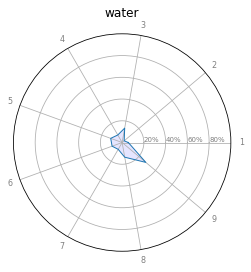

In [303]:
plot_spider_ingredient("water",lda_data)

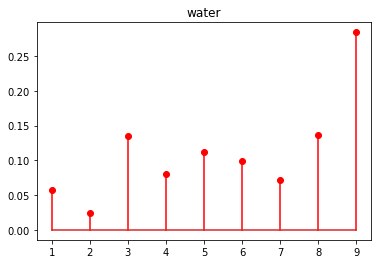

In [304]:
plot_dna_ingredient("water",lda_data)

#### Category 1

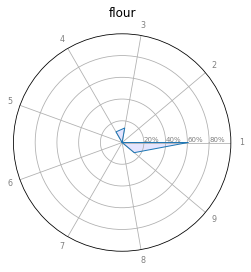

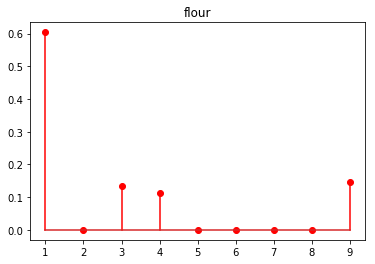

In [305]:
# See data story.
ingredient = "flour"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)


#### Category 2

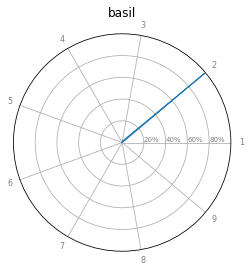

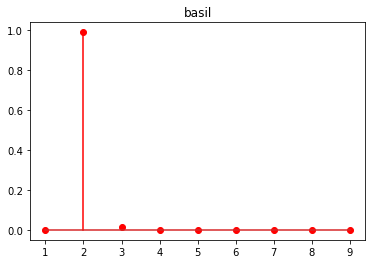

In [306]:
# See data story.
ingredient = "basil"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

#### Category 3

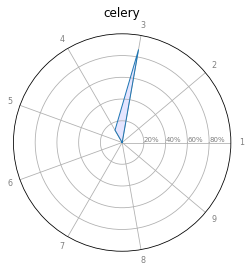

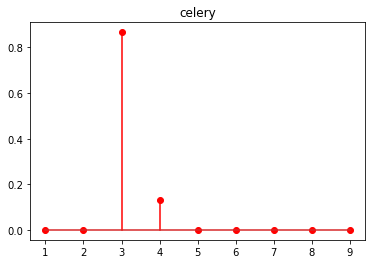

In [307]:
# See data story.
ingredient = "celery"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

#### Category 4

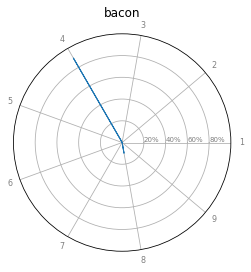

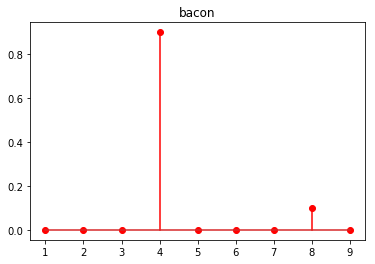

In [308]:
# See data story.
ingredient = "bacon"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### Category 5

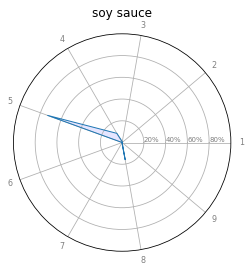

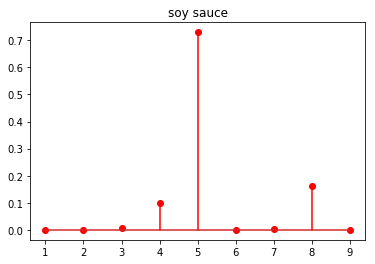

In [309]:
# See data story.
ingredient = "soy sauce"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### Category 6

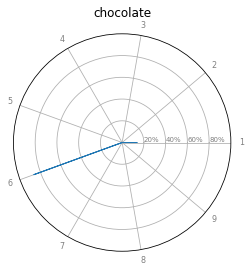

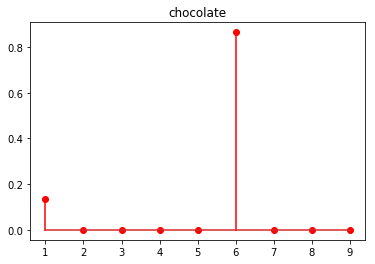

In [310]:
# See data story.
ingredient = "chocolate"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### Category 7

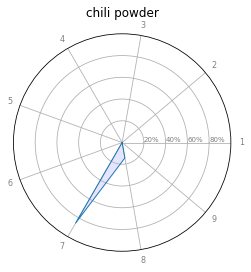

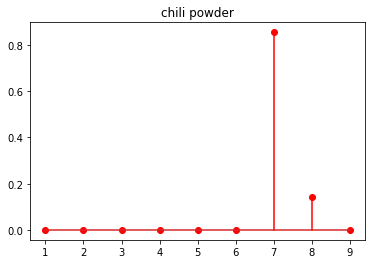

In [311]:
# See data story.
ingredient = "chili powder"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### Category 8

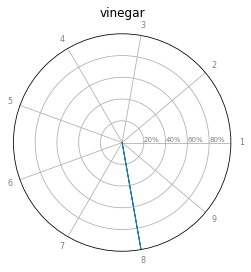

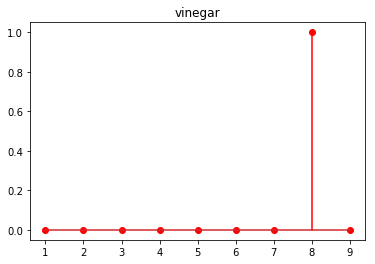

In [312]:
# See data story.
ingredient = "vinegar"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### Category 9

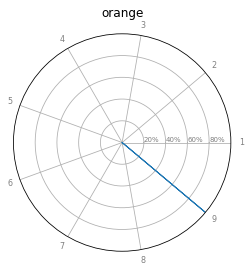

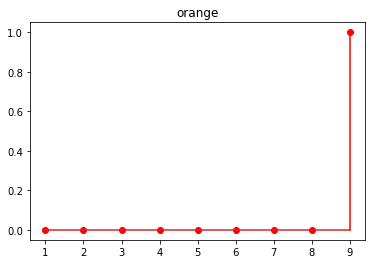

In [313]:
# See data story.
ingredient = "orange"
plot_spider_ingredient(ingredient,lda_data)
plot_dna_ingredient(ingredient,lda_data)

### 2.3 Visualize topic distribution of ingredients.

To visualize the topic distribution of an ingredient it is best to look at the saliency of the term. That way we get a better idea of how relevant it is for each topic. The implementation of these functions are in the helpers_lda.py and are heaviliy based on the pyLDAvis documentations and examples.

In [286]:
import numpy as np
import helpers_lda as lda_h

def plot_spider_ingredient(ingredient,lda_data):
    s = lda_h.top_term_topics(ingredient,lda_data,sort=False)
    
    N = len(s)

    values = list(s.values)
    values = list(np.array(values)/sum(np.array(values)))
    values.append(values[0])
    
    categories = list(s.keys())
    categories.append(categories[0]) # make the cirle round 
    
    
    
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]


    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1],categories , color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    
    plt.yticks([0.2,0.4,0.6,0.8], ["20%","40%","60%","80%"], color="grey", size=7)

    plt.ylim(0,1)

    # Plot data
    plt.title(ingredient)


    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig("figures/"+ingredient+"_spider.png")


    plt.show()

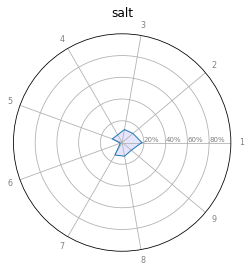

In [134]:
plot_spider_ingredient("salt",lda_data)

Maybe it would be better to visualize this in a different way. In a DNA plot.

In [302]:
def plot_dna_ingredient(ingredient,lda_data):
    s = lda_h.top_term_topics(ingredient,lda_data,sort=False)
    
    N = len(s)

    values = list(s.values)
    values = list(np.array(values)/sum(np.array(values)))
    
    categories = list(s.keys())
    plt.stem(categories,values, markerfmt='ro',linefmt='r-')
    plt.savefig("figures/"+ingredient+"_dna.png")

    plt.title(ingredient)
    plt.show()
    
    
   

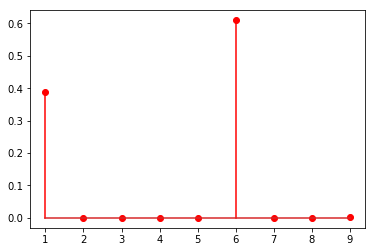

In [136]:
plot_dna_ingredient("vanilla",lda_data)

Note that each ingredient is somehow distributed over the different categories. Hence we could say that each ingredient has somehow a dna in the different categories. 

### 2.4 The LDA DNA

In [137]:
#To do this we first need to make the categories of the pyldavis and the normal lda model correspond
correspond_dict = lda_h.create_mapping_dict(lda_data,finalDf,lda_model,dictionary)
#Note that somehow some things are wrongly classified

misses: 0.002659089131624912


In [138]:
import helpers_lda as lda_h

In [139]:
finalDf.finalIngredients.sample(4)

22062    {'provolone', 'salt', 'balsamic vinegar', 'olive oil', 'onion', 'bread'}                                                                                                          
16963    {'chips', 'monterey jack cheese', 'apple juice', 'sour cream', 'pinto beans', 'cilantro', 'chicken breast', 'lime', 'salami', 'onion', 'taco seasoning', 'chicken broth', 'olive'}
36523    {'parsley', 'olive oil', 'butter', 'mushroom', 'bacon', 'garlic', 'baguette', 'parmesan', 'onion'}                                                                                
10167    {'salt', 'tarragon', 'olive oil', 'mushroom', 'garlic', 'vegetable oil', 'onion', 'tomato'}                                                                                       
Name: finalIngredients, dtype: object

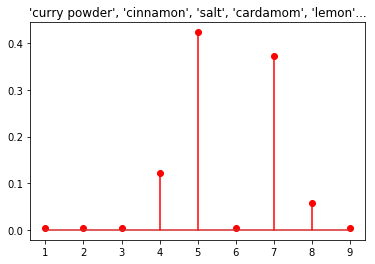

In [140]:
im.reload(lda_h)
def plot_dna_list(ingredient_list, lda_model):
    s = pd.Series(OrderedDict(lda_model.get_document_topics(dictionary.doc2bow(ingredient_list),minimum_probability=0)))
    s = lda_h.map_series(s,correspond_dict)
    N = len(s)

    values = list(s.values)
    
    categories = list(np.array(list(s.keys())))
    maxl = 5
    if len(ingredient_list)>maxl:
        title = str(ingredient_list[0:maxl])
        title = title[1:len(title)-1]+ "..."
    else:
        title= str(ingredient_list)[1:len(str(ingredient_list))-1]
    plt.title(title)
    plt.stem(categories,values, markerfmt='ro',linefmt='r-')
    
    plt.show()
plot_dna_list(['curry powder', 'cinnamon', 'salt', 'cardamom', 'lemon', 'chicken soup', 'ghee', 'coconut milk', 'coriander', 'mustard seed', 'butter', 'cilantro', 'garlic', 'ginger', 'onion', 'turmeric', 'chicken breast', 'cumin', 'mint', 'tomato paste', 'peppercorn'],lda_model)
    

Let's have a look at a random sample of our recipies. 

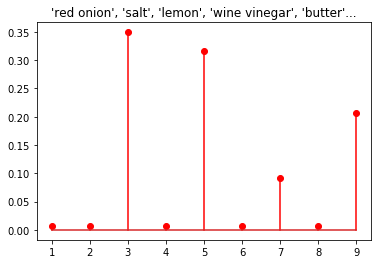

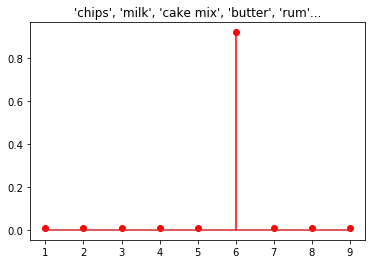

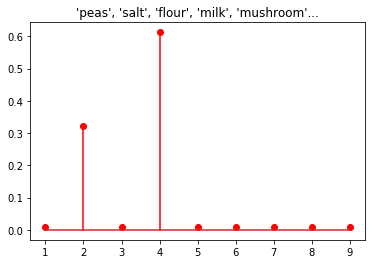

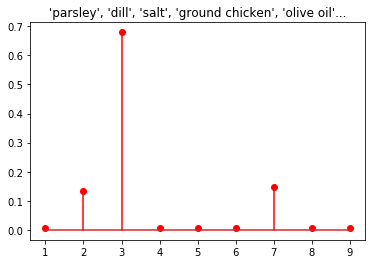

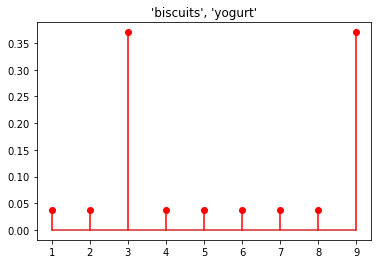

In [141]:
sub = [list(eval(s)) for s in finalDf.finalIngredients.sample(5,random_state=1)]
for s in sub:
    plot_dna_list(s,lda_model)
    

We can see that the DNA is in some cases not that colorfull. this is mainly the case with baking stuff and when it is classified with some terms that are really obviously in one specific topic.

## 3. A deeper look into the network analysis

This section we take a deeper look into the food network taht we built as described in milestone II.
The foodnetwork is loaded with pickle.

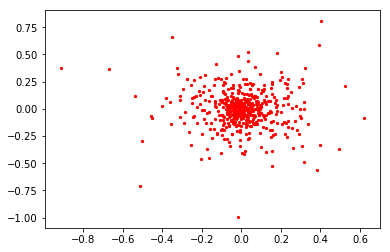

In [269]:
#Loading the network through the pickle file
import pickle 
f = open ('store.pckl', 'rb')
network = pickle.load(f)
#Plotting the Nodes
pos = nx.spring_layout(network, dim=3, k=None, pos=None, fixed=None, iterations=200, weight='weight')

nx.draw_networkx_nodes(network, pos, node_size=5)
plt.show()



In [270]:
plt.savefig("network.png")

As one can see the network is quite dense, let's have a look at some basic properties.
The average degree of a node: 

In [85]:
#As one can see the network is quite dense, let's have a look at some basic properties.
nodes = list(network.nodes())
edges = list(network.edges())
#Average Degree
number_nodes = len(nodes)
number_edges = len(edges)
average_degree = 2*number_edges/number_nodes
average_degree

207.94970986460348

Wow this is heavely connected indeed! Let's also have a look at the longest possible path in the network, the diameter.

In [86]:
nx.diameter(network)

3

This means that ingredients are no further than 3 intermediate ingredients away from each other. To get an even better idea of the network we will look at the ingredients that are never connected together.

In [99]:
import pprint
no_connect1 = {}
#diff with first neighbors
for node in nodes:
    diff = set(nodes) - set(network.neighbors(node))
    diff.remove(node)
    no_connect1[node] = diff
print(len(no_connect1))

517


In [96]:
#diff second neighbours
no_connect2 = {}
for node in nodes:
    first_neighbors = list(network.neighbors(node))
    second_neighbors = []
    for first_neighbor in first_neighbors:
        second_neighbors = second_neighbors + list(network.neighbors(first_neighbor))

    all_neighbors = first_neighbors + second_neighbors
    diff = set(nodes) - set(all_neighbors)
    #diff.remove(node)
    if len(diff)>0:
        no_connect2[node] = diff
    all_neighbors = []
pprint.pprint(no_connect2)

{'barramundi': {'bloody mary'},
 'beef liver': {'grenadine', 'filo dough', 'bloody mary', 'curacao'},
 'bloody mary': {'barramundi',
                 'beef liver',
                 'bologna',
                 'can tuna',
                 'cockle',
                 'creme de menthe',
                 'custard',
                 'frangelico',
                 'margarita mix',
                 'muenster',
                 'pizza cheese',
                 'shaoxing wine',
                 'shortcrust pastry',
                 'star fruit'},
 'bologna': {'bloody mary', 'pizza cheese'},
 'can tuna': {'bloody mary',
              'filo dough',
              'hummus',
              'octopus',
              'pollock',
              'shaoxing wine'},
 'chicken gravy': {'filo dough', 'grenadine'},
 'cockle': {'filo dough', 'bloody mary', 'grenadine'},
 'creme de menthe': {'bloody mary'},
 'curacao': {'beef liver'},
 'custard': {'bloody mary'},
 'filo dough': {'beef liver',
                'can tu

In [92]:
len(no_connect2)

23

Only 23 ingredients that are not connected as second neighbours! 

Due to the heavy density of this network and the extremely high degree of the nodes we decided not to use the network any further in our analysis. 

## 4. Making the twist

The goal of this section is to come up with an algorithm that suggests nice twists to a given list of ingredients. The algorithm works as follows. 
1. Get the DNA list of the user input
2. We search for recipes in the known database with similar DNA's 
3. In this subset we look for a nice ingredient to add.
    

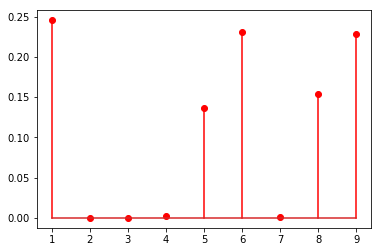

In [148]:
plot_dna_ingredient("sugar",lda_data)

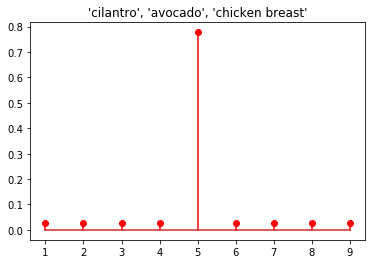

In [145]:
user_input = ["cilantro","avocado","chicken breast"]
#Get the DNA of the user input matched 
plot_dna_list(user_input,lda_model)
s = pd.Series(OrderedDict(lda_model.get_document_topics(dictionary.doc2bow(user_input),minimum_probability=0)))
dna_user = lda_h.map_series(s,correspond_dict)

This looks, unfortunatly pretty monotone however we are free to suggest new ingredients. To get a better idea of which directions we can head with this ingredient combintation we look at the ingredient_dna based on the saliency scores. Then we will overlay it to get a broader spectrum of the ingredient combination. We will call this the enriched dna. 

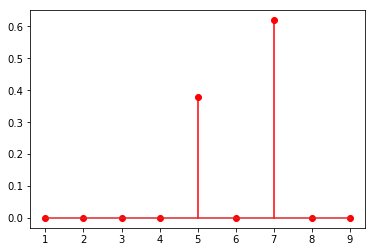

In [159]:
plot_dna_ingredient("cilantro",lda_data)

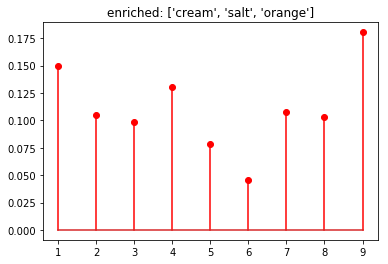

In [249]:
keys = [1, 2, 3, 4, 5, 6, 7, 8, 9]
user_input = ["cream","salt","orange"]

def make_enriched_dna(user_input,lda_data,nb_topics):
    dna = np.zeros(nb_topics)
    for ingredient in user_input:
        s = get_dna_ingredient(ingredient,lda_data)
        dna = dna + get_dna_ingredient(ingredient,lda_data)
    dna = dna/np.sum(dna)
    return dna

make_enriched_dna(user_input,lda_data,9) 
def plot_enriched_dna(user_indput,lda_data,nb_topics):
    
    dna = make_enriched_dna(user_input,lda_data,nb_topics)
    plt.title("enriched: "+str(user_input))
    plt.stem(keys,dna, markerfmt='ro',linefmt='r-')
    plt.show()
plot_enriched_dna(user_input,lda_data,9)

We can still see that categories the same categories are present however no we also get the option to go into direction of the other categories. The way we handle this is as follows:
1. Out of the enriched dna we select two or three directions that we want to go with this ingredient list
2. We suggest the user some ingredients out of each direction and ask for feedback. Since each category is a certain cuisine and the user might not be a fan of mexican food we give him this choice instead of taking a random direction.
3. With the suggested category we find a similar recipe in the database and propose this.

In [250]:
def extract_best_categories(user_input,lda_data,nb_topics):
    enriched_dna = make_enriched_dna(user_input,lda_data,nb_topics)
    s = pd.Series(OrderedDict(lda_model.get_document_topics(dictionary.doc2bow(user_input),minimum_probability=0)))
    s = lda_h.map_series(s,correspond_dict)
    
    
    #We do not want the match to be to close => no match with biggest normal category
    #normal_dna = np.array(list(s.values))
    #print(normal_dna)
    
    #index_max = np.argmax(normal_dna)
    #enriched_dna[index_max] = 0 
    #get index of three biggest elements
    enriched_dna.argsort()[-3:][::-1]
    return  enriched_dna.argsort()[-3:][::-1]+1
categories = extract_best_categories(user_input,lda_data,9) 

In [252]:
im.reload(lda_h)
def suggest_ingredients(user_input, categories, lda_data, nb_topics):
    suggested_ingredients = []
    return lda_h.top_topic_terms(categories,lda_data)
   
b = suggest_ingredients(user_input, categories, lda_data, 9)
b.head(5) 


,9,1,4
0,sugar,flour,onion
1,water,salt,butter
2,orange,sugar,cheddar
3,salt,eggs,salt
4,rose water,butter,cream


In [261]:
def filter_input_categories(selected_category,input_categories):
    treshold = 0.5
    input_filtered = input_categories.loc[input_categories[selected_category] >= treshold]
    return input_filtered

def recipies_with_similar_ingredients(input_filtered,user_input):
    #Filter based of the common ingredients in that set.
    indexes = input_filtered.index.tolist()
    similarDict = {}
    for index in indexes: 
        s = eval(finalDf.finalIngredients.iloc[index])
        t = set(user_input)
        if len(s&t)>1:
            similarDict[index] = len(s&t)
    #Get out the N biggest values by flipping the dictionary
    different_lengths = list(set(similarDict.values()))
    flippeddict = dict(zip(list(set(similarDict.values())), [[] for i in range(0,len(different_lengths))]))
    for key,value in similarDict.items():
        flippeddict[value].append(key)
    return flippeddict
from random import randint
def find_recipies(user_input,selected_category,lda_data,nb_topics):
    # Look in the known data base for recipies that have a dependency on that category
    input_categories = lda_data['doc_topic_dists']
    input_filtered = filter_input_categories(selected_category,input_categories)
    
    # Find recipies with similar ingredients.
    flipped_dict = recipies_with_similar_ingredients(input_filtered,user_input)
    
    # We get the best matching recipies
    N = 12 #max number of recipies
    flipped_values = list(flipped_dict.keys())
    best_match_len = max(flipped_values)
    flipped_values.remove(best_match_len)
    second_best_match_len = max(flipped_values)
    recipies = flipped_dict[best_match_len]
    if len(recipies)>N:
        #Randomly pick a sample
        recipies = recipies[0:N]
    elif len(recipies)<N:
        #Take second best match
        recipies = recipies+  flipped_dict[second_best_match_len][0:N-(len(recipies))]
        
        
    
    return recipies

                

        
indeces = find_recipies(user_input,4,lda_data,9)

In [262]:
finalDf[["ingredients_list","finalIngredients"]].loc[indeces]

,ingredients_list,finalIngredients
7011,"4 cup (or more) low-salt chicken broth|2 tablespoon (1/4 stick) butter|1 bunch green onions, white parts finely chopped, green parts thinly sliced|1 cup arborio or medium-grain rice|1/2 cup dry white wine|1/4 cup freshly grate parmesan cheese|2 tablespoon mascarpone cheese or whipping cream|1 teaspoon finely grate orange peel","{'cream', 'salt', 'orange', 'mascarpone', 'butter', 'parmesan', 'onion', 'rice', 'white wine', 'chicken broth'}"
129,"1 (2 pound) package freeze hash brown potatoes, thawed|1/2 cup melt butter|1 (10.75 ounce) can condense cream of chicken soup|12 ounce shred american cheese|1 (8 ounce) container sour cream|1 teaspoon salt|1/2 onion, chopped|2 cup crush cornflakes cereal|1/2 cup melt butter","{'cream', 'salt', 'american cheese', 'sour cream', 'chicken soup', 'cereal', 'onion', 'peanut butter'}"
268,2 tablespoon butter|2 tablespoon all-purpose flour|1/2 teaspoon salt|1/4 teaspoon white pepper|1 teaspoon chicken bouillon granules|2 tablespoon finely chop onion|1 1/2 cup half-and-half cream|1/2 pound medium shrimp - peel and deveined|1/2 pound pre-cooked crab meat|1/2 cup white wine,"{'shrimp', 'cream', 'salt', 'flour', 'butter', 'crab', 'bouillon', 'onion', 'chili pepper', 'white wine'}"
479,"1 pound fresh asparagus, trim and cut into 1/2 inch pieces|10 slice bacon|2 (8 inch) unbaked pie shells|1 egg white, lightly beaten|4 eggs|1 1/2 cup half-and-half cream|1/4 teaspoon ground nutmeg|salt and pepper to taste|2 cup shred swiss cheese","{'cream', 'asparagus', 'salt', 'bacon', 'swiss cheese', 'ground nutmeg', 'eggs'}"
639,1 (8 ounce) package cook egg noodles|2 tablespoon butter|1 (6 ounce) can slice mushrooms|1 teaspoon salt|1/8 teaspoon pepper|2 cup chop cook turkey|1 (10.75 ounce) can condense cream of celery soup|1 cup sour cream|1/2 cup grate parmesan cheese,"{'cream', 'salt', 'pepperoni', 'sour cream', 'mushroom', 'butter', 'turkey', 'noodle', 'parmesan', 'celery soup'}"
774,1 package (2 pound size) freeze hash brown potatoes|1 carton (16 ounce size) sour cream|1 can (10.75 ounce size) cream of celery soup|1 cup shred sharp cheddar cheese|1/2 cup butter or margarine|1 teaspoon salt|1 teaspoon coarsely ground black pepper|1/2 cup round buttery cracker crumbs|1 dash tabasco sauce,"{'cream', 'salt', 'cheddar', 'cracker', 'sour cream', 'butter', 'celery soup'}"
884,"cooking spray|2 tablespoon vegetable oil|4 skinless, boneless chicken breast halves|1/2 teaspoon salt|1/4 teaspoon ground black pepper|1 1/2 pound fresh asparagus, trimmed|1 (10.75 ounce) can condense cream of chicken soup|1/2 cup mayonnaise|1 teaspoon lemon juice|1 cup shred cheddar cheese","{'cream', 'salt', 'asparagus', 'cheddar', 'apple juice', 'chicken breast', 'mayonnaise', 'chicken soup', 'vegetable oil', 'cooking spray'}"
954,"1 recipe pastry for a 9 inch double crust pie|1 carrot, chopped|1 head fresh broccoli, chopped|2 boneless chicken breast halves, cook and chopped|1 (10.75 ounce) can condense cream of chicken soup|2/3 cup milk|1 cup shred cheddar cheese|1/2 teaspoon salt","{'cream', 'salt', 'cheddar', 'milk', 'broccoli', 'chicken breast', 'carrot', 'chicken soup'}"
1037,"2 1/2 lb hash brown (i use fresh package hb found in dairy section of groc. store-takes 2 packs.)|1/2 lb of shred cheddar cheese|1/2 cup onion, diced|2 cup heavy cream (whipping)|1 teaspoon salt","{'cream', 'onion', 'salt', 'cheddar'}"
1155,"3 tablespoon butter|1 clove garlic, sliced|1/2 teaspoon salt|1/8 teaspoon ground white pepper|1 cup milk|1/2 cup half-and-half cream|1 pint fresh shuck oysters|2 tablespoon chop fresh parsley (optional)|1 pinch cayenne pepper (optional)|1/4 cup sherry wine, or to taste (optional)","{'cream', 'parsley', 'cayenne', 'salt', 'milk', 'butter', 'garlic', 'sherry', 'oyster'}"


Evaluation, so what direction did we take? Let's have look at the distribution of our chosen indeces.

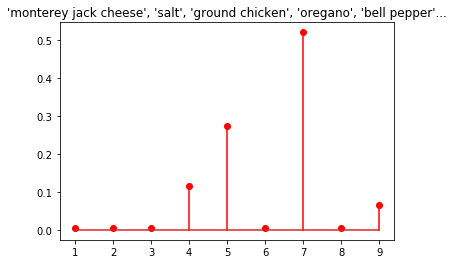

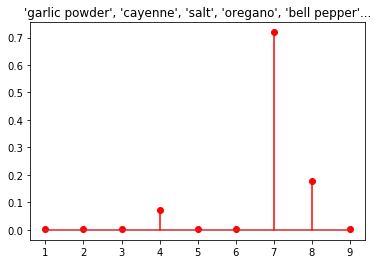

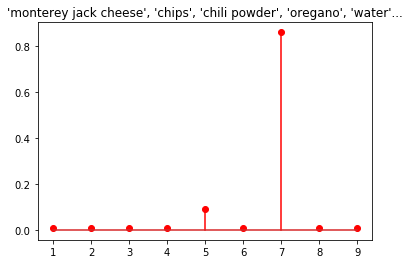

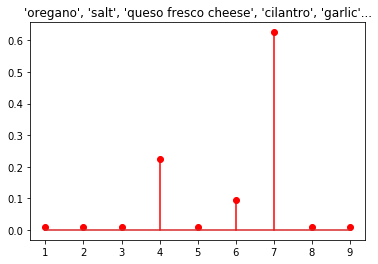

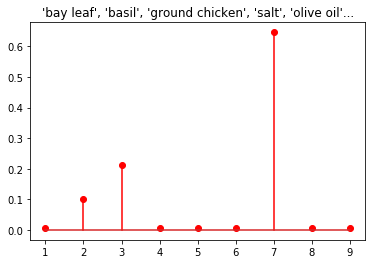

In [248]:
for index in indeces:
    plot_dna_list(list(eval(finalDf.finalIngredients.loc[index])),lda_model)

That looks like a varied meal!

## 6. Who did what? 

* Adriaan: everything except network analysis and data story
* Claas : network analysis and data story and poster
* Amimul : Tried to make plots, didn't work. He made one but did not manage to integrate it in our notebook. 

In [318]:
from IPython.core.display import display, HTML
HTML(filename="dna_amimul.html")